In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

! pip install --upgrade tensorflow tensorflow-io

In [2]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

2024-11-03 11:55:46.514159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 11:55:46.538893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730652946.556116  751384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730652946.561394  751384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 11:55:46.579317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'          # Suppresses most TensorFlow info and warning messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'         # Disables oneDNN optimizations (optional)

In [5]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [6]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels


In [7]:
# Setting up file paths for training and testing
train_dir = r'/projectnb/ds340/students/apvasco/Training/'
test_dir = r'/projectnb/ds340/students/apvasco/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


## Initial Data Visualizations

Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Testing Counts
{'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


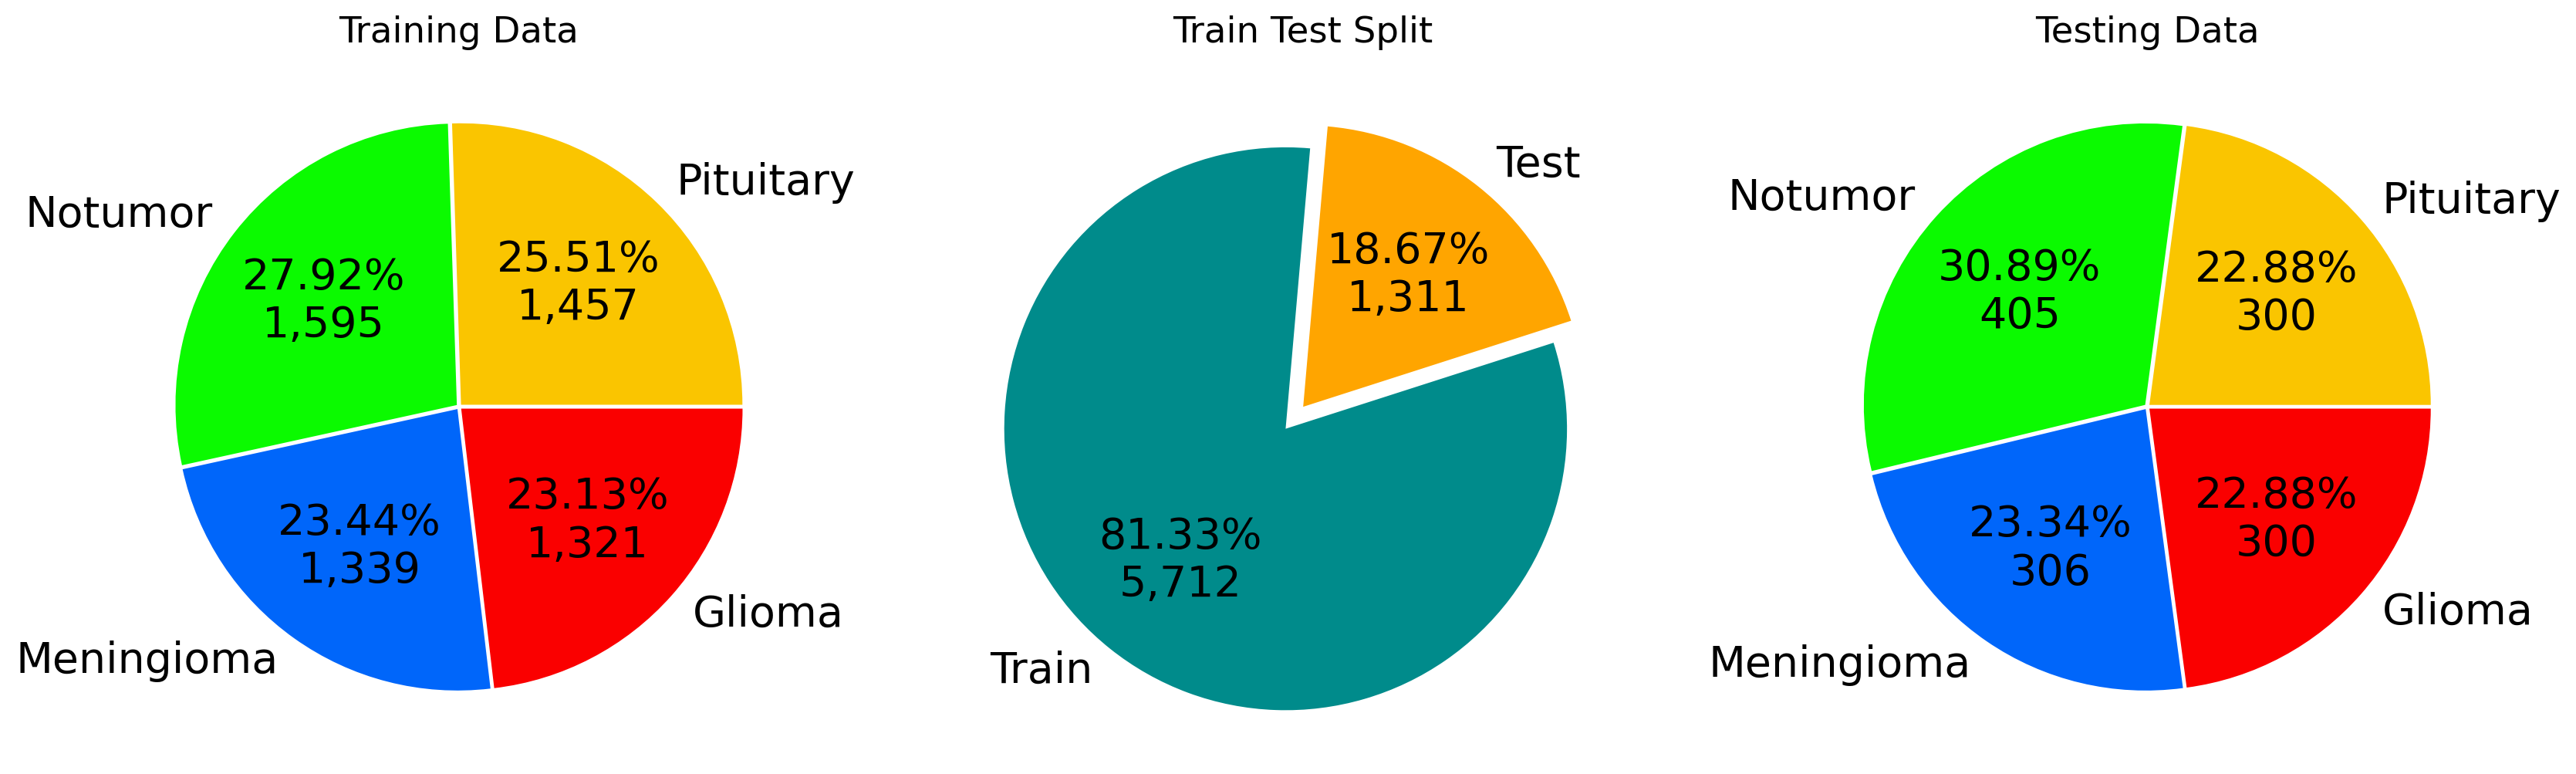

In [8]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

x reshaped: (1, 150, 150, 3)


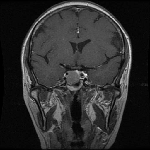

In [9]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [10]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


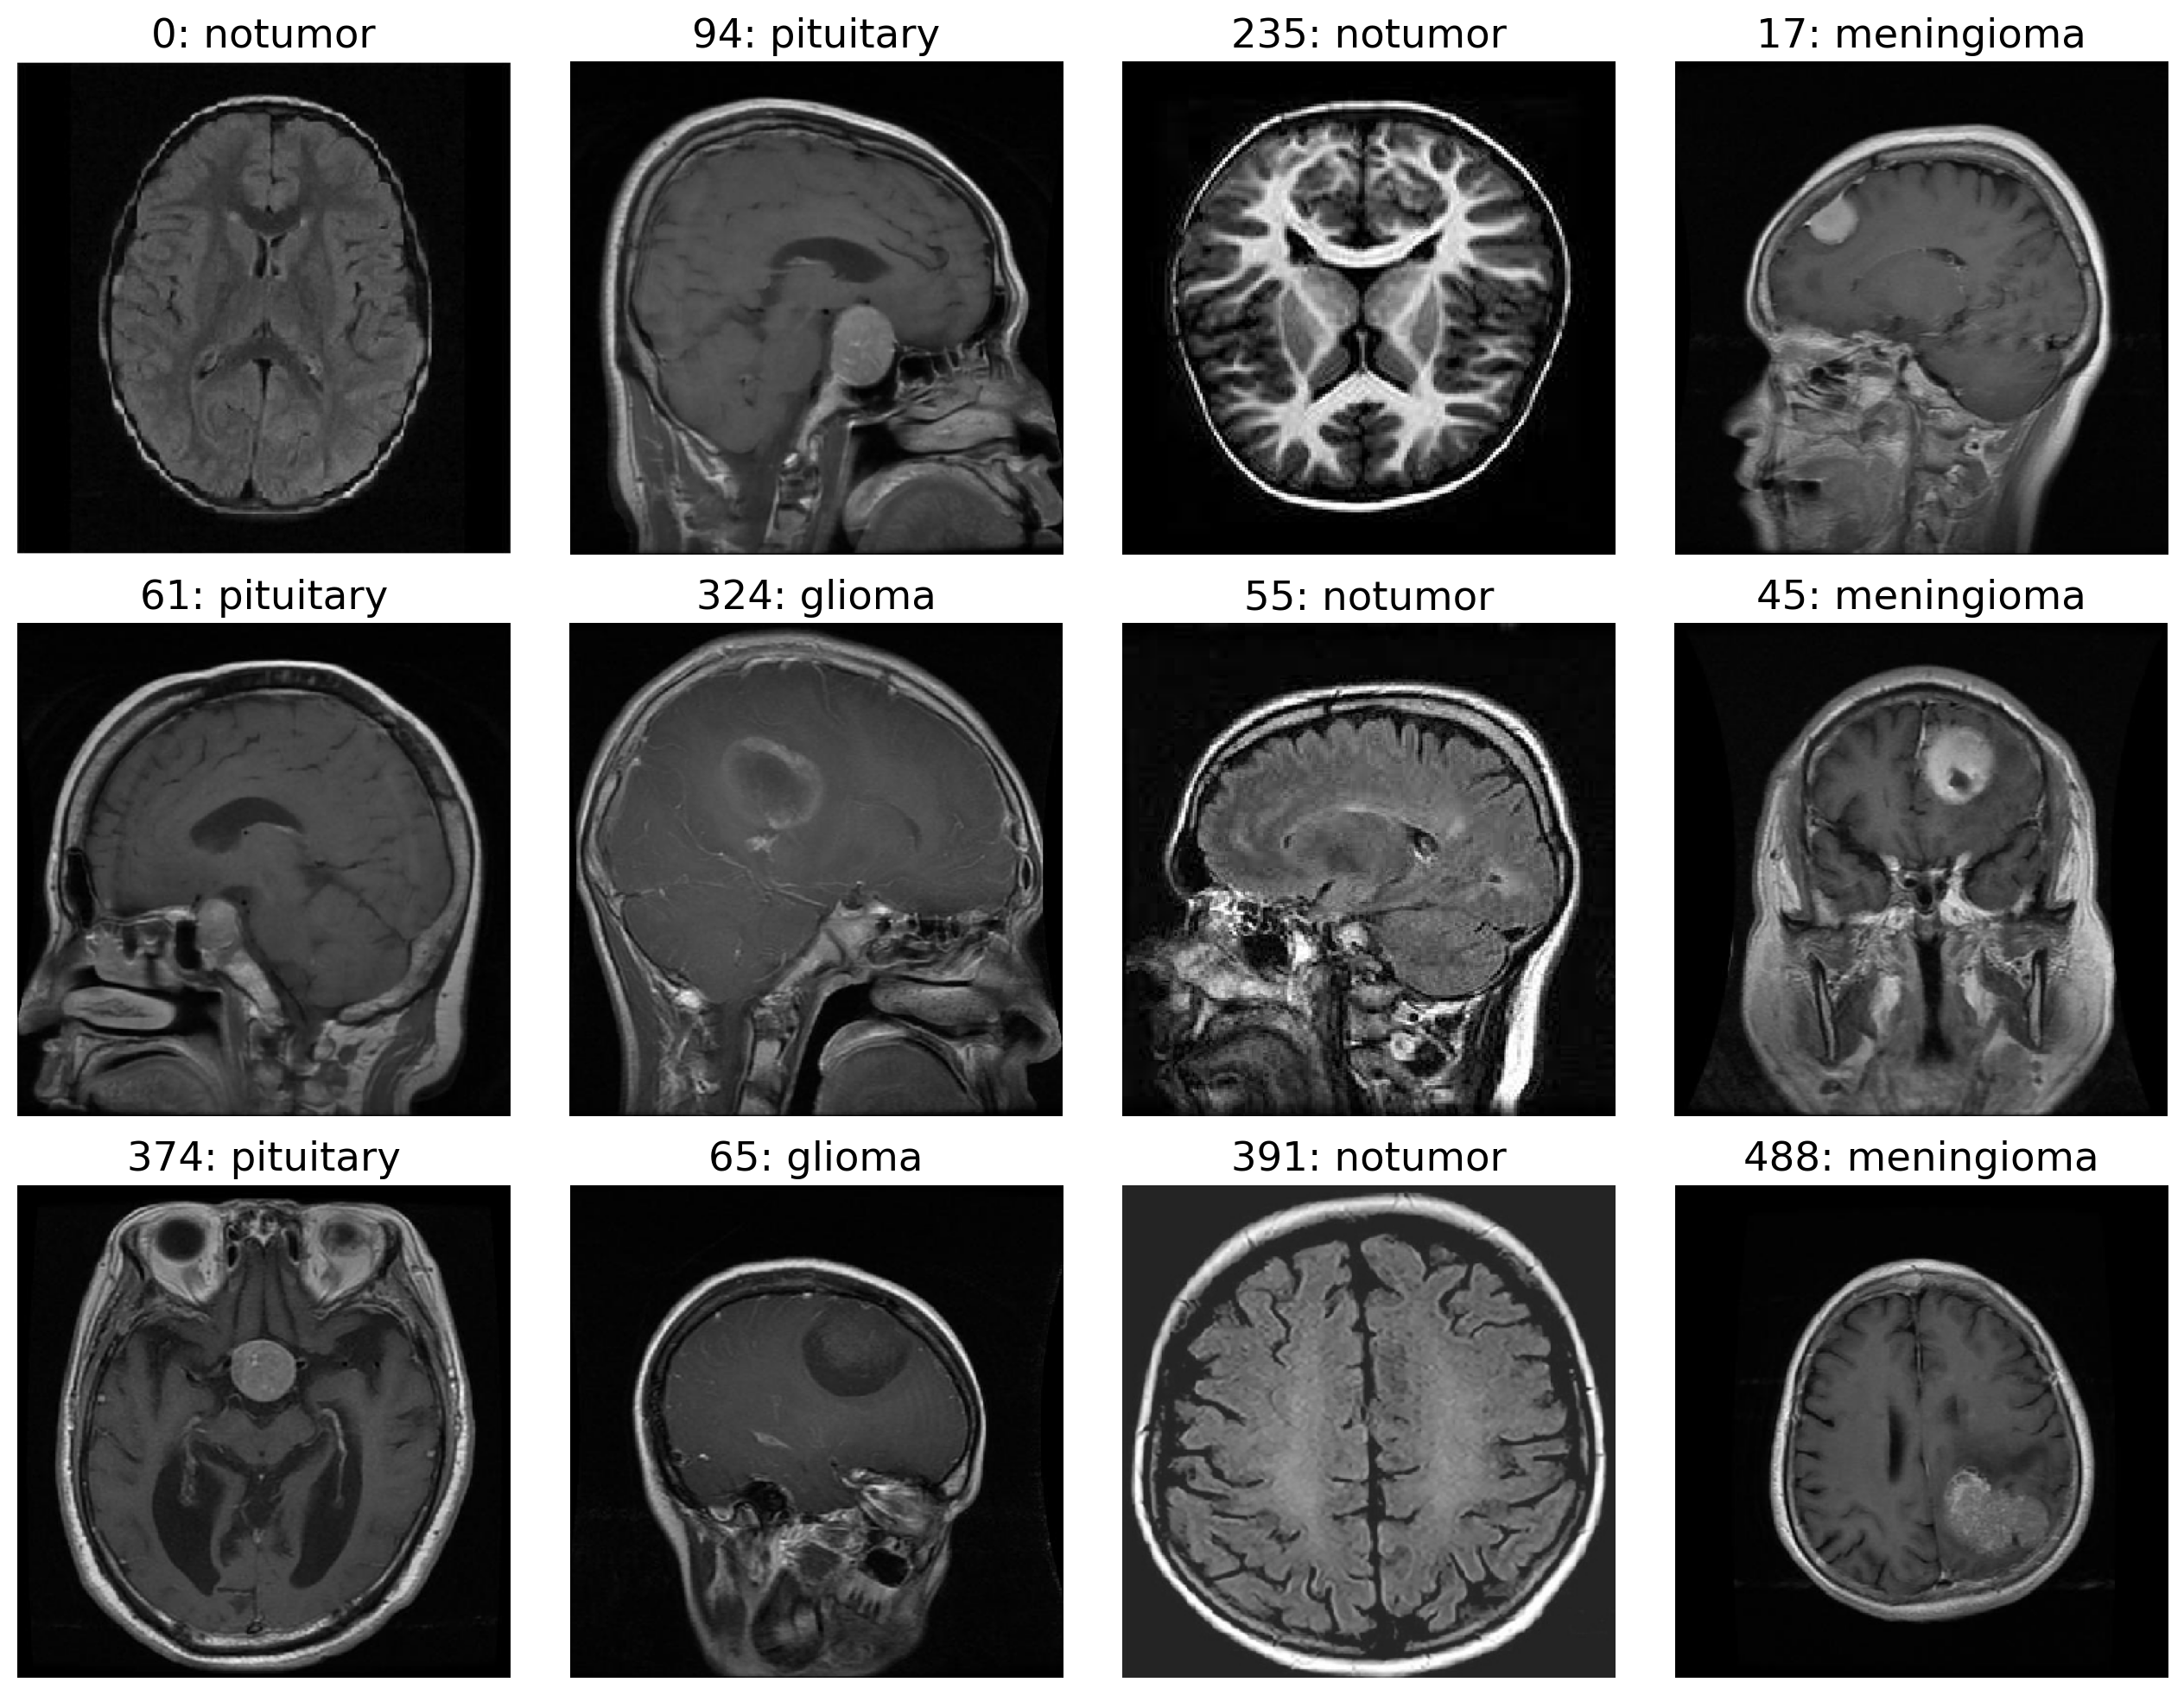

In [11]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

In [12]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [13]:
# Data augmentation and preprocessing
#ImageDataGenerator used in tensor flow to help preprocess images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Data Augmentation Class Indices

In [14]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Data Augmentation of the Images

In [15]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = next(train_generator)

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()


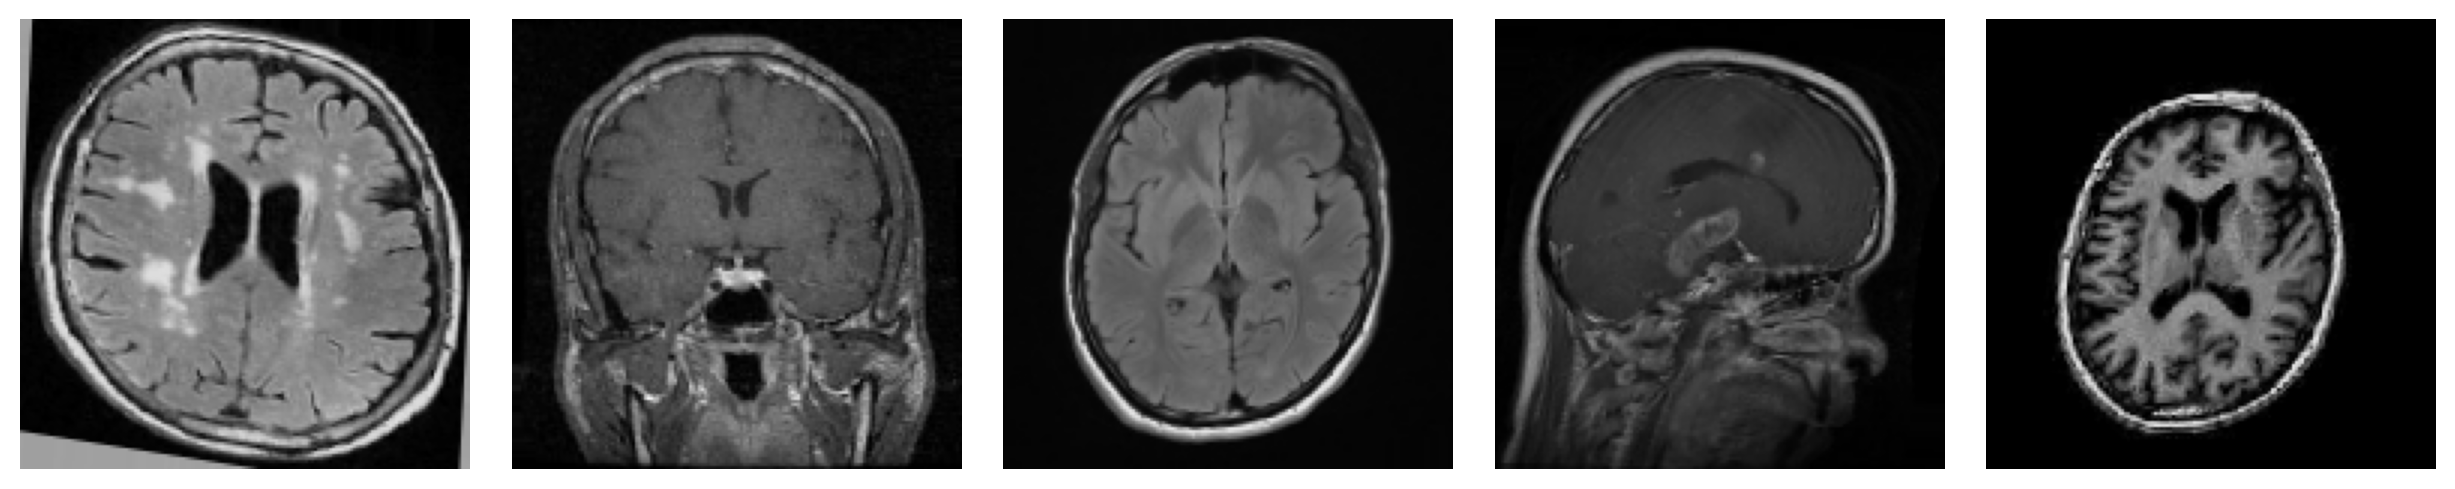

In [16]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=SAVE)

# Training Setup Values

In [17]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


# Evaluation Metrics for Multiclass Classification for the Neural Network


In [18]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


# CNN Model

In [19]:
# Set random seed for reproducibility
tf.random.set_seed(SEED)

model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Fully connected layers
    Dense(512, activation="relu"),
    Dropout(0.5),  # Dropout layer without internal seed
    Dense(N_TYPES, activation="softmax")
])

model.summary()

# Use the standard Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730653487.852919  751384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:18:00.0, compute capability: 7.0
I0000 00:00:1730653487.853374  751384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14784 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
W0000 00:00:1730653488.131055  752498 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Now add visual Keras

In [20]:
!pip install visualkeras

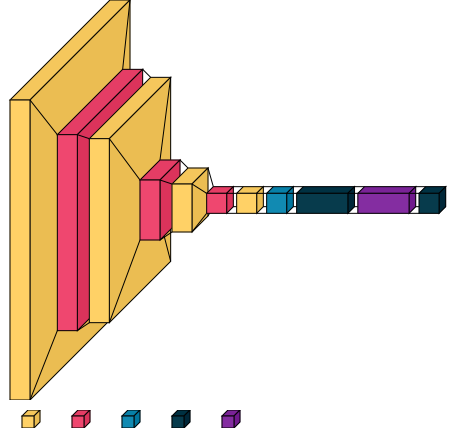

In [21]:
from visualkeras import layered_view

import warnings
warnings.filterwarnings("ignore", message="The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")

# Then visualize the model
from visualkeras import layered_view
layered_view(model, legend=True, max_xy=300)


# convolutional - yellow
# pooling - pink
# flatten - teal
# dense - dark blue
# dropout - purple
# for presentation add these later on? 

# Training the Model

In [22]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [23]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1730653509.778343  752486 service.cc:148] XLA service 0x14854401e390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730653509.778366  752486 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1730653509.778369  752486 service.cc:156]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-11-03 12:05:09.813857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1730653509.976710  752486 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compi

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/runpy.py", line 86, in _run_code

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/scratch/922646.1.academic-gpu/ipykernel_751384/3374975840.py", line 6, in <module>

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/projectnb/ds340/students/apvasco/.conda/envs/av_conda_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_2417]